In [5]:
import os
import glob
import torch.nn.functional as F
import networkx
import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from torch.utils.data import Dataset

# dnri
from dnri.utils.flags import build_flags
import dnri.models.model_builder as model_builder
import dnri.training.train_utils as train_utils
import dnri.training.train as train
import dnri.training.evaluate as evaluate
import dnri.utils.misc as misc
from dnri.utils.data_utils import *

def normalize(y):
	m1 = y.mean(axis=(1,0))
	s1 = y.std(axis=(1,0))
	return (y-m1)/s1

# def normalize(y):
#     return y

# def normalize(y):
#     left_wr = y[5,:]
#     y = y - left_wr
#     y = rotate_and_normalize(y)
#     return y

# def rotation_matrix_from_vectors(vec1, vec2):
#     """Find the rotation matrix that aligns vec1 to vec2."""
#     a = vec1 / np.linalg.norm(vec1)
#     b = vec2 / np.linalg.norm(vec2)
#     v = np.cross(a, b)
#     c = np.dot(a, b)
#     s = np.linalg.norm(v)
    
#     if s == 0:
#         return np.eye(3)  # Already aligned
    
#     vx = np.array([[0, -v[2], v[1]],
#                    [v[2], 0, -v[0]],
#                    [-v[1], v[0], 0]])
#     R = np.eye(3) + vx + vx @ vx * ((1 - c) / (s ** 2))
#     return R

# def rotate_and_normalize(y):
#     """Rotate and normalize the vectors so that y[20] aligns with (1,0,0)."""
    
#     target = np.array([1, 0, 0])
#     R = rotation_matrix_from_vectors(y[20,:], target)

#     y = y / np.linalg.norm(y[20,:])  # Normalize  
#     y = (R @ y.T).T  # Apply rotation
#     return y
   
def compute_velocity(points, delta_t=1):
	"""
	Compute the velocity among 3D points in a matrix.
	
	Args:
	points (np.ndarray): A numpy array of shape (N, 3) where N is the number of points and each point has 3 coordinates (x, y, z).
	
	Returns:
	np.ndarray: A numpy array of shape (N-1, 3) representing the velocity between consecutive points.
	"""
	velocities = (points[1:] - points[:-1])*delta_t
	return velocities

def load_files(folder_path, compute_velocity_b=False, substring='*.npy', equalize=False, eq_axis=0, target_size=150):

	# load train, val and test data	
	pattern = os.path.join(folder_path, 'tr*' + substring)
	file_names = glob.glob(pattern)
	train_data = []
	for file in file_names:
		d = np.load(file)
		# d = d.transpose(0,1,3,2)[:,:,0,:]
		d = d.transpose(0,1,3,2).reshape((d.shape[0], d.shape[1], d.shape[2]*d.shape[3]))
		d = np.transpose(d, (1, 2, 0))

		if equalize:
			d, delta_t = equalize_ndarray(d, axis=eq_axis, target_size=target_size)
		
		# add velocity
		if compute_velocity_b:
			d = np.pad(d, ((0, 0), (0, 0), (0, 3)), mode='constant', constant_values=0)
			velocities = compute_velocity(d[:, :, :3], delta_t)
			d[1:, :, 3:] = velocities
      
		for i in range(d.shape[0]):
			d[i] = normalize(d[i])

		if np.max(np.sum((np.linalg.norm(np.diff(d, axis=0), axis=2)), axis = 1)) < 25:
			train_data.append(d)
		# train_data.append(d)
	
	pattern = os.path.join(folder_path, 'va*'+substring)
	file_names = glob.glob(pattern)
	val_data = []
	for file in file_names:
		#print("Loading file:", file)
		d = np.load(file)
		d = d.transpose(0,1,3,2).reshape((d.shape[0], d.shape[1], d.shape[2]*d.shape[3]))
		d = np.transpose(d, (1, 2, 0))
		if equalize:
			d, delta_t = equalize_ndarray(d, axis=eq_axis, target_size=target_size)

		# add velocity
		if compute_velocity_b:
			d = np.pad(d, ((0, 0), (0, 0), (0, 3)), mode='constant', constant_values=0)
			velocities = compute_velocity(d[:, :, :3], delta_t)
			d[1:, :, 3:] = velocities
   	
		for i in range(d.shape[0]):
			d[i] = normalize(d[i])
		
		if np.max(np.sum((np.linalg.norm(np.diff(d, axis=0), axis=2)), axis = 1)) < 25:
			val_data.append(d)
		# val_data.append(d)
	
	pattern = os.path.join(folder_path, 'te*'+substring)
	file_names = glob.glob(pattern)
	test_data = []
	for file in file_names:
		#print("Loading file:", file)
		d = np.load(file)
		d = d.transpose(0,1,3,2).reshape((d.shape[0], d.shape[1], d.shape[2]*d.shape[3]))
		d = np.transpose(d, (1, 2, 0))
		if equalize:
			d, delta_t = equalize_ndarray(d, axis=eq_axis, target_size=target_size)

		# add velocity
		if compute_velocity_b:
			d = np.pad(d, ((0, 0), (0, 0), (0, 3)), mode='constant', constant_values=0)
			velocities = compute_velocity(d[:, :, :3], delta_t)
			d[1:, :, 3:] = velocities	
      
		for i in range(d.shape[0]):
			d[i] = normalize(d[i])
		if np.max(np.sum((np.linalg.norm(np.diff(d, axis=0), axis=2)), axis = 1)) < 25:
			test_data.append(d)
		# test_data.append(d)

	print("Train data len: ", len(train_data))
	print("Val data len  : ", len(val_data))
	print("Test data len : ", len(val_data))
	print("Train data size: ", train_data[0].shape)
	print("Val data size  : ", val_data[0].shape)
	print("Test data size : ", test_data[0].shape)
	return train_data, val_data, test_data

def equalize_ndarray(arr, axis=0, target_size=None):
	"""
	Equalize a numpy ndarray along a specified axis by undersampling or uppersampling by a fixed quantity.
	
	Parameters:
	arr (numpy.ndarray): Input array to be equalized.
	axis (int): Axis along which to equalize the array.
	target_size (int): Target size for the specified axis. If None, the size of the smallest dimension along the axis is used.
	
	Returns:
	numpy.ndarray: Equalized array.
	"""
      
	if target_size is None:
		target_size = min(arr.shape[axis])
	
	current_size = arr.shape[axis]
	indices = np.arange(current_size)
      
	delta_t = target_size/current_size
	
	if current_size > target_size:
		# Undersampling
		indices = np.linspace(0, current_size - 1, target_size).astype(int)
	elif current_size < target_size:
		# Oversampling
		indices = np.linspace(0, current_size - 1, target_size).astype(int)
	
	equalized_arr = np.take(arr, indices, axis=axis)
	return equalized_arr, delta_t

class ActionDataset(Dataset):
	def __init__(self, data):
		self.data = data
		self.min_dim = np.min([s.shape[0] for s in self.data])
		self.max_dim = np.max([s.shape[0] for s in self.data])
		print("Min/max time steps: ", self.min_dim, self.max_dim)

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		return self.data[idx]

class CmuMotionData(Dataset):
    def __init__(self,
                 mode, 
                 name='cmu', 
                 data_path='', 
                 test_full=False, 
                 mask_ind_file=None):
        self.name = name
        self.data_path = data_path
        self.mode = mode
        self.train_data_len = -1
        # Get preprocessing stats.
        loc_max, loc_min, vel_max, vel_min = self._get_normalize_stats()
        self.loc_max = loc_max
        self.loc_min = loc_min
        self.vel_max = vel_max
        self.vel_min = vel_min
        self.test_full = test_full

        # Load data.
        self._load_data()
        self.expand_train = False
        if self.mode == 'train' and self.expand_train and self.train_data_len > 0:
            self.all_inds = []
            for ind in range(len(self.feat)):
                t_ind = 0
                while t_ind < len(self.feat[ind]):
                    self.all_inds.append((ind, t_ind))
                    t_ind += self.train_data_len
        else:
            self.expand_train = False

    def __getitem__(self, index):
        if self.expand_train:
            ind, t_ind = self.all_inds[index]
            start_ind = np.random.randint(t_ind, t_ind + self.train_data_len)

            feat = self.feat[ind][start_ind:start_ind + self.train_data_len]
            if len(feat) < self.train_data_len:
                feat = self.feat[ind][-self.train_data_len:]
            return {'inputs':feat}
        else: 
            inputs = self.feat[index]
            size = len(inputs)
            if self.mode == 'train' and self.train_data_len > 0 and size > self.train_data_len:
                start_ind = np.random.randint(0, size-self.train_data_len)
                inputs = inputs[start_ind:start_ind+self.train_data_len]
            result = {'inputs': inputs}
        return result

    def __len__(self, ):
        if self.expand_train:
            return len(self.all_inds)
        else:
            return len(self.feat)

    def _get_normalize_stats(self,):
        train_loc = np.load(self._get_npy_path('loc', 'train'), allow_pickle=True)
        train_vel = np.load(self._get_npy_path('vel', 'train'), allow_pickle=True)
        try:
            train_loc.max()
            self.dynamic_len = False
        except:
            self.dynamic_len = True
        if self.dynamic_len:
            max_loc = max(x.max() for x in train_loc)
            min_loc = min(x.min() for x in train_loc)
            max_vel = max(x.max() for x in train_vel)
            min_vel = min(x.min() for x in train_vel)
            return max_loc, min_loc, max_vel, min_vel
        else:
            return train_loc.max(), train_loc.min(), train_vel.max(), train_vel.min()

    def _load_data(self, ):
        #print('***Experiment hack: evaling on training.***')
        # Load data
        self.loc_feat = np.load(self._get_npy_path('loc', self.mode), allow_pickle=True)
        self.vel_feat = np.load(self._get_npy_path('vel', self.mode), allow_pickle=True)
        #self.edge_feat = np.load(self._get_npy_path('edges', self.mode))

        # Perform preprocessing.
        if self.dynamic_len:
            self.loc_feat = [normalize(feat, self.loc_max, self.loc_min) for feat in self.loc_feat]
            self.vel_feat = [normalize(feat, self.vel_max, self.vel_min) for feat in self.vel_feat]
            self.feat = [np.concatenate([loc_feat, vel_feat], axis=-1) for loc_feat, vel_feat in zip(self.loc_feat, self.vel_feat)]
            self.feat = [torch.from_numpy(np.array(feat, dtype=np.float32)) for feat in self.feat]
            print("FEATURE LEN: ",len(self.feat))
        else:
            self.loc_feat = normalize(self.loc_feat, self.loc_max, self.loc_min)
            self.vel_feat = normalize(self.vel_feat, self.vel_max, self.vel_min)

            # Reshape [num_sims, num_timesteps, num_agents, num_dims]
            #self.loc_feat = np.transpose(self.loc_feat, [0, 1, 3, 2])
            #self.vel_feat = np.transpose(self.vel_feat, [0, 1, 3, 2])
            self.feat = np.concatenate([self.loc_feat, self.vel_feat], axis=-1)

            # Convert to pytorch cuda tensor.
            self.feat = torch.from_numpy(
                np.array(self.feat, dtype=np.float32))  # .cuda()

            # Only extract the first 49 frame if testing.
            if self.mode == 'test' and not self.test_full:
                self.feat = self.feat[:, :49]

    def _get_npy_path(self, feat, mode):
        return '%s/%s_%s_%s.npy' % (self.data_path,
                                    feat,
                                    mode,
                                    self.name)

def plot_landmarks(points):
	# Separare le coordinate x e y
	x_coords = [point[0] for point in points]
	y_coords = [point[1] for point in points]
	fig = go.Figure(data=go.Scatter(x=x_coords, y=y_coords, mode='markers'))
	fig.update_layout(
		title='Grafico di coppie di punti',
		xaxis_title='Asse X',
		yaxis_title='Asse Y',
		xaxis=dict(scaleanchor='y', scaleratio=1),
		yaxis=dict(scaleanchor='x', scaleratio=1)
	)
	fig.show()

# move to base dir
print("Current dir:", os.getcwd())

if True:
    params = {}
    params['fixed_window_len'] = 40
    params['working_dir'] = 'out'
    params['num_vars'] = 42  					# num landmarks
    params['input_noise_type'] = 'none'
    params['input_size'] = 3					# num feats: pos. & vel. for each landmark
    params['input_time_steps'] = 100
    params['nll_loss_type'] = 'gaussian'
    params['prior_variance'] = 5e-2
    name = 'face_landmarks'
    params['encoder_no_factor'] = False
    params['gumbel_temp'] = 0.5
    params['num_edge_types'] = 2
    params['encoder_dropout'] = 0.05
    params['decoder_dropout'] = 0.05
    params['decoder_hidden'] = 256
    params['encoder_hidden'] = 256
    params['encoder_rnn_hidden'] = 64
    params['encoder_mlp_hidden'] = 128
    params['encoder_rnn_type'] = 'lstm'
    params['decoder_rnn_type'] = 'gru'
    params['encoder_mlp_num_layers'] = 3
    params['prior_num_layers'] = 3
    params['prior_hidden_size'] = 128
    params['gpu'] = True
    params['continue_training'] = False
    params['skip_first'] = False
    params['load_best_model'] = False
    params['num_epochs'] = 100
    params['load_model'] = False
    params['lr'] = 5e-4
    params['lr_decay_factor'] = 0.5
    params['lr_decay_patience'] = 30
    params['lr_decay_steps'] = 300 
    params['training_scheduler'] = None
    params['step_size'] = 10
    params['batch_size'] = 4
    params['val_batch_size'] = 1
    params['accumulate_steps'] = 1
    params['verbose'] = True
    params['use_adam'] = True
    params['clean_log_dir'] = True
    params['clip_grad'] = None
    params['clip_grad_norm'] = None

Current dir: /home/studenti/agnelli/projects/nri


In [6]:
# load data
path = "/home/studenti/agnelli/projects/nri/data"
train_data, val_data, test_data = load_files(path, equalize=True, eq_axis=0, target_size=100)

Train data len:  1963
Val data len  :  606
Test data len :  606
Train data size:  (100, 42, 3)
Val data size  :  (100, 42, 3)
Test data size :  (100, 42, 3)


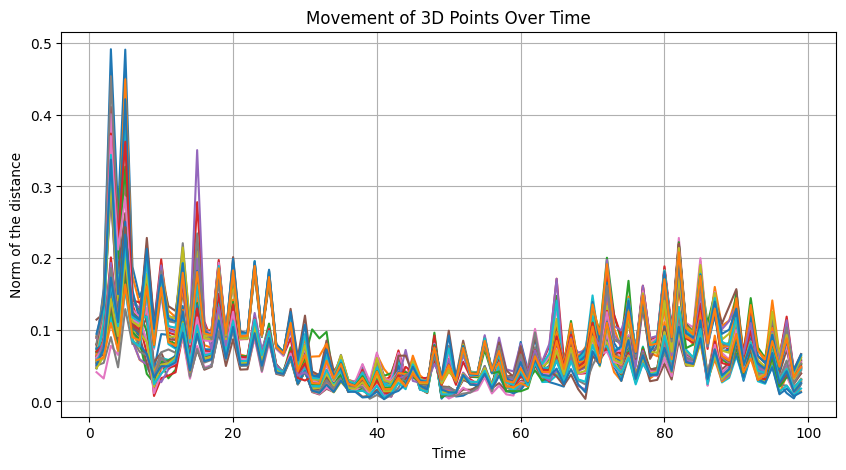

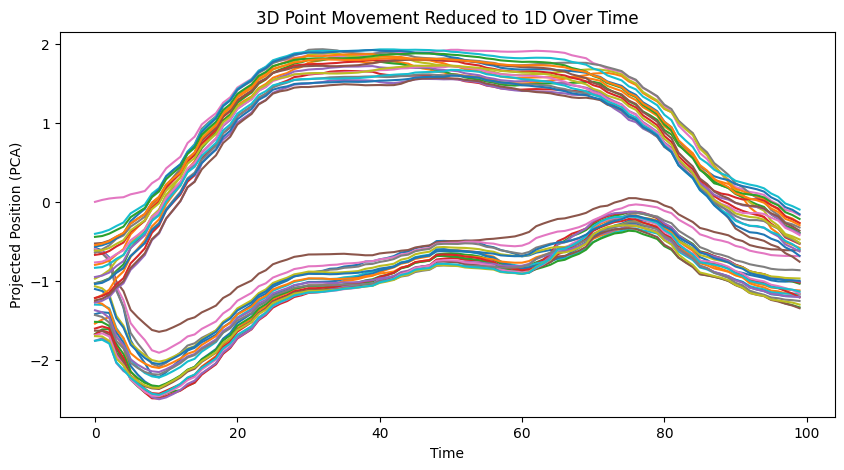

Big distance at sample 0 with value  6.7515836
Big distance at sample 1 with value  7.953205
Big distance at sample 2 with value  4.6309276
Big distance at sample 3 with value  10.628072
Big distance at sample 4 with value  4.224188
Big distance at sample 5 with value  7.86412
Big distance at sample 6 with value  5.4073424
Big distance at sample 7 with value  10.17065
Big distance at sample 8 with value  8.560236
Big distance at sample 9 with value  8.228924
Big distance at sample 10 with value  7.2113156
Big distance at sample 11 with value  6.0104156
Big distance at sample 12 with value  8.015962
Big distance at sample 13 with value  12.056788
Big distance at sample 14 with value  12.819492
Big distance at sample 15 with value  11.839519
Big distance at sample 16 with value  8.557977
Big distance at sample 17 with value  12.0975275
Big distance at sample 18 with value  8.915191
Big distance at sample 19 with value  9.596753
Big distance at sample 20 with value  11.594581
Big distance

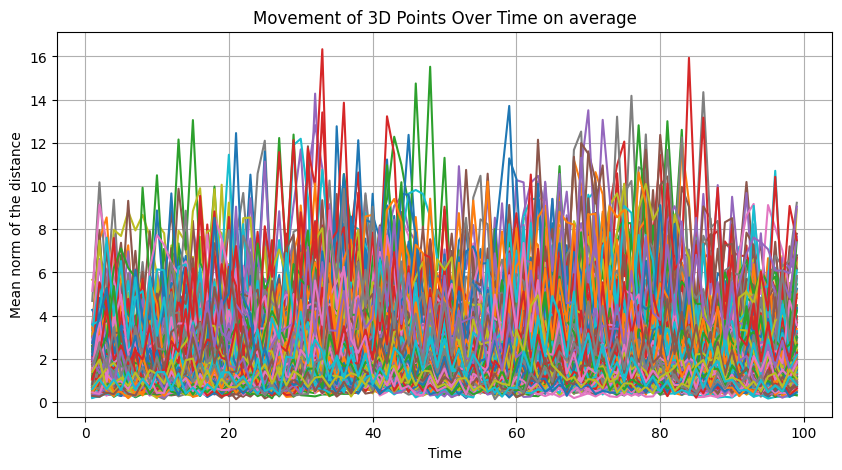

In [7]:
import numpy as np
import matplotlib.pyplot as plt

t, n = 100, 42
y = train_data[952]
# y = val_data[9]
distances = np.linalg.norm(np.diff(y, axis=0), axis=2)  # Shape (t-1, n)

# Plot
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.plot(range(1, 100), distances[:, i], label=f'Point {i+1}')

plt.xlabel('Time')
plt.ylabel('Norm of the distance')
plt.title('Movement of 3D Points Over Time')
plt.grid()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Flatten y over time to fit PCA (concatenating all time steps)
# y = train_data[952]
y_reshaped = y.reshape(t * n, 3)

# Apply PCA to reduce 3D to 1D
pca = PCA(n_components=1)
y_pca = pca.fit_transform(y_reshaped).reshape(t, n)  # Reshape back to (t, n)

# Plot the PCA-transformed values over time
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.plot(range(t), y_pca[:, i], label=f'Point {i+1}')

plt.xlabel("Time")
plt.ylabel("Projected Position (PCA)")
plt.title("3D Point Movement Reduced to 1D Over Time")
plt.show()


mean_distance = []
i = 0
for land in train_data:
    distances = np.linalg.norm(np.diff(land, axis=0), axis=2)  # Shape (t-1, n)
    mean_distance.append(np.sum(distances, axis=1))
    if np.max(mean_distance[i])>3:
        print("Big distance at sample", i, "with value ", np.max(mean_distance[i]))
    i += 1

# Plot
plt.figure(figsize=(10, 5))
for i in range(200):
    plt.plot(range(1, 100), mean_distance[i])

plt.xlabel('Time')
plt.ylabel('Mean norm of the distance')
plt.title('Movement of 3D Points Over Time on average')
plt.grid()
plt.show()

In [13]:
# left_hand = train_data[0][:, :21, :]
# right_hand = train_data[0][:, 21:, :]
# # convert to torch tensor
# left_landmarks = torch.tensor(left_hand, dtype=torch.float32)
# right_landmarks = torch.tensor(right_hand, dtype=torch.float32)
hands = train_data[952]
# convert to torch tensor
landmarks = torch.tensor(hands, dtype=torch.float32)

A = torch.tensor([[4,19],[3,16],[2,13],[1,10],[19,18],[16,15],[13,12],[10,9],[18,17],[15,14],[12,11],[9,8],[17,5],[14,5],[11,5],[8,5],[0,7],[7,6],[6,5],[20,5]])
A = torch.cat([A,A+21], dim=0)

torch.max(abs(landmarks))

tensor(10.9757)

In [17]:
import plotly.graph_objects as go

n=35

# Create the initial 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=landmarks[n][:, 0],
            y=landmarks[n][:, 1],
            z=landmarks[n][:, 2],
            mode='markers',
            marker=dict(size=2, color="red", opacity=0.7)
        )]+[
        go.Scatter3d(
                    x=[landmarks[n][i, 0], landmarks[n][j, 0]],
                    y=[landmarks[n][i, 1], landmarks[n][j, 1]],
                    z=[landmarks[n][i, 2], landmarks[n][j, 2]],
                    mode='lines',
                    line=dict(color='blue', width=1),
                ) for i, j in A  # Adjacency matrix updates per frame
    ]+[
        go.Scatter3d(
            x=landmarks[n][20:21, 0],
            y=landmarks[n][20:21, 1],
            z=landmarks[n][20:21, 2],
            mode='markers',
            marker=dict(size=2, color="black", opacity=0.7)
        )],
    layout=go.Layout(
        title="Evolution of landmarks",
        # scene=dict(
        #     xaxis=dict(range=[-3, 3]),  # Set appropriate axis ranges
        #     yaxis=dict(range=[-3, 3]),
        #     zaxis=dict(range=[-3, 3]),
        #     aspectmode="cube"  # Ensures equal scaling for all axes
        # ),
        updatemenus=[{
            "buttons": [
                {"args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}],
                 "label": "Play",
                 "method": "animate"},
                {"args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                 "label": "Pause",
                 "method": "animate"}
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }]
    ),
    frames=[
        go.Frame(
            data=[
                go.Scatter3d(
                    x=landmarks[t][:, 0],
                    y=landmarks[t][:, 1],
                    z=landmarks[t][:, 2],
                    mode='markers',
                    marker=dict(size=2, color="red", opacity=0.7)
                )
            ] + [
                go.Scatter3d(
                    x=[landmarks[t][i, 0], landmarks[t][j, 0]],
                    y=[landmarks[t][i, 1], landmarks[t][j, 1]],
                    z=[landmarks[t][i, 2], landmarks[t][j, 2]],
                    mode='lines',
                    line=dict(color='blue', width=1),
                ) for i, j in A  # Adjacency matrix updates per frame
            ] + [
                go.Scatter3d(
                    x=landmarks[t][20:21, 0],
                    y=landmarks[t][20:21, 1],
                    z=landmarks[t][20:21, 2],
                    mode='markers',
                    marker=dict(size=2, color="red", opacity=0.7)
                )
            ],
            name=f"Frame {n+t}"
        ) for t in range(n, len(landmarks))
    ]
)

# Show the animated plot
fig.show()

In [4]:
# make datasets
cut_size = 100
cut_size1 = 20
train_dataset = ActionDataset(train_data[0:cut_size])
val_dataset = ActionDataset(val_data[0:cut_size1])
test_dataset = ActionDataset(test_data[0:cut_size1])

from torch.utils.data import DataLoader

params['batch_size'] = 2

# # Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params['val_batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=params['val_batch_size'], shuffle=False)

Min/max time steps:  100 100
Min/max time steps:  100 100
Min/max time steps:  100 100
Train dataset len:  100


# BASELINE

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class RecurrentPredictor(nn.Module):
    def __init__(self, input_dim=63, hidden_dim=64, num_layers=1, horizon = 10):
        super(RecurrentPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)
        self.horizon = horizon

    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Predict only the last 10% of the sequence
        output = self.fc(lstm_out)
        output = output[:, -self.horizon:, :]
        
        return output

def train_lstm(model, train_loader, criterion, optimizer, num_epochs=20, device="cuda", scheduler=None):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)  # Move batch to GPU if available
            
            seq_len = batch.shape[1]
            split_idx = int(seq_len * 0.9)

            x_train = batch[:, :split_idx, :]  # First 90%
            y_true = batch[:, split_idx:, :]  # Last 10%
            b, t, n, d = y_true.shape

            optimizer.zero_grad()
            y_pred = model(x_train.reshape(x_train.shape[0], x_train.shape[1], -1))
            y_pred = y_pred.reshape(b, t, n, d)

            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        if scheduler is not None:
            scheduler.step(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    return avg_loss

def test_lstm(model, test_loader, criterion, device="cuda"):
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            b, t, n, d = batch.shape

            seq_len = batch.shape[1]
            split_idx = int(seq_len * 0.9)

            x_test = batch[:, :split_idx, :]  # First 90%
            y_true = batch[:, split_idx:, :]  # Last 10%
            b, t, n, d = y_true.shape

            y_pred = model(x_test.reshape(x_test.shape[0], x_test.shape[1], -1))
            y_pred = y_pred.reshape(b, t, n, d)

            loss = criterion(y_pred, y_true)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")


device = "cuda" if torch.cuda.is_available() else "cpu"
model = RecurrentPredictor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

avg_loss = train_lstm(model, train_loader, criterion, optimizer, num_epochs=200, device=device, scheduler = scheduler)
print(f"Average Training Loss: {avg_loss:.4f}")
test_lstm(model, test_loader, criterion, device=device)



RuntimeError: input.size(-1) must be equal to input_size. Expected 63, got 126

In [84]:
# graphic test for the previous model

x = torch.tensor(train_data[40:41], dtype=torch.float32)[0]
x_train = x[:90]
y_test = x[90:]
y_pred = model(x_train.unsqueeze(0).reshape(1, 90, -1).to("cuda"))
y_pred = y_pred.reshape(1, 10, 21, 3).cpu().squeeze(0).detach().numpy()

A = torch.tensor([[4,19],[3,16],[2,13],[1,10],[19,18],[16,15],[13,12],[10,9],[18,17],[15,14],[12,11],[9,8],[17,5],[14,5],[11,5],[8,5],[0,7],[7,6],[6,5],[20,5]])

import plotly.graph_objects as go

n=0

# Create the initial 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=y_test[n][:, 0],
            y=y_test[n][:, 1],
            z=y_test[n][:, 2],
            mode='markers',
            marker=dict(size=2, color="red", opacity=0.7)
        )]+[
        go.Scatter3d(
                    x=[y_test[n][i, 0], y_test[n][j, 0]],
                    y=[y_test[n][i, 1], y_test[n][j, 1]],
                    z=[y_test[n][i, 2], y_test[n][j, 2]],
                    mode='lines',
                    line=dict(color='blue', width=1),
                ) for i, j in A  # Adjacency matrix updates per frame
    ]+[
        go.Scatter3d(
            x=y_pred[n][:, 0],
            y=y_pred[n][:, 1],
            z=y_pred[n][:, 2],
            mode='markers',
            marker=dict(size=2, color="green", opacity=0.7)
        )],
    layout=go.Layout(
        title="Evolution of landmarks",
        updatemenus=[{
            "buttons": [
                {"args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}],
                 "label": "Play",
                 "method": "animate"},
                {"args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                 "label": "Pause",
                 "method": "animate"}
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }]
    ),
    frames=[
        go.Frame(
            data=[
                go.Scatter3d(
                    x=y_test[t][:, 0],
                    y=y_test[t][:, 1],
                    z=y_test[t][:, 2],
                    mode='markers',
                    marker=dict(size=2, color="red", opacity=0.7)
                )
            ] + [
                go.Scatter3d(
                    x=[y_test[t][i, 0], y_test[t][j, 0]],
                    y=[y_test[t][i, 1], y_test[t][j, 1]],
                    z=[y_test[t][i, 2], y_test[t][j, 2]],
                    mode='lines',
                    line=dict(color='blue', width=1),
                ) for i, j in A  # Adjacency matrix updates per frame
            ] + [
                go.Scatter3d(
                    x=y_pred[t][:, 0],
                    y=y_pred[t][:, 1],
                    z=y_pred[t][:, 2],
                    mode='markers',
                    marker=dict(size=2, color="green", opacity=0.7)
                )
            ],
            name=f"Frame {n+t}"
        ) for t in range(n, len(y_pred))
    ]
)

# Show the animated plot
fig.show()

# DNRI

In [4]:
# def DNRI model
params['model_type'] = 'nri'
params['graph_type'] = 'static'
model_DNRI = model_builder.build_model(params)

(1722,)
(1722,)
Using factor graph MLP encoder.
ENCODER:  RefMLPEncoder(
  (mlp1): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=300, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.05, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp2): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.05, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp3): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ELU(alpha=1.

In [6]:
# train DNRI model
params['num_epochs'] = 1
DO_TRAIN = True
if DO_TRAIN:
	train.train(model_DNRI, train_data, val_data, params, None, None)

EPOCH 1 0
	BATCH 1 OF 957: 12.394033, 11.430455, 0.963578
	UPDATING WEIGHTS
	BATCH 2 OF 957: 133.375381, 12.061895, 121.313484
	UPDATING WEIGHTS
	BATCH 3 OF 957: 12.190103, 6.678730, 5.511373
	UPDATING WEIGHTS
	BATCH 4 OF 957: 59.275864, 8.433750, 50.842113
	UPDATING WEIGHTS
	BATCH 5 OF 957: 45.589310, 6.060627, 39.528687
	UPDATING WEIGHTS
	BATCH 6 OF 957: 22.717794, 11.931072, 10.786722
	UPDATING WEIGHTS
	BATCH 7 OF 957: 15.580720, 7.215554, 8.365167
	UPDATING WEIGHTS
	BATCH 8 OF 957: 46.217094, 27.029446, 19.187651
	UPDATING WEIGHTS
	BATCH 9 OF 957: 33.953617, 12.603590, 21.350027
	UPDATING WEIGHTS
	BATCH 10 OF 957: 16.042973, 8.076571, 7.966403
	UPDATING WEIGHTS
	BATCH 11 OF 957: 26.130320, 18.474445, 7.655874
	UPDATING WEIGHTS
	BATCH 12 OF 957: 20.138241, 8.942886, 11.195354
	UPDATING WEIGHTS
	BATCH 13 OF 957: 15.602813, 7.592404, 8.010408
	UPDATING WEIGHTS
	BATCH 14 OF 957: 15.021420, 4.795022, 10.226397
	UPDATING WEIGHTS
	BATCH 15 OF 957: 18.060385, 13.101772, 4.958613
	UPDATING 

In [ ]:
### TEST
# path = os.path.join(params['working_dir'], 'best_model')
# model.load(path)  # LOADING BEST MODEL
T = params['input_time_steps']
M = int(0.9*T)  # prediction steps
P = T - M       # GT steps
test_cumulative_mse_DNRI, predictions_DNRI, GTs = evaluate.eval_forward_prediction(model_DNRI, test_data, P, M, params)

# Plot the data
plt.figure(figsize=(8, 4))
plt.plot(test_cumulative_mse_DNRI, label='MSE')
plt.xlabel('k-step')
plt.ylabel('MSE')
plt.title(f'MSE: {M}-step forward prediction on {T} total steps')
plt.legend()
plt.show()

In [ ]:
### plot points
print(predictions_DNRI[0].shape)
sbj = 4
M = 30
P0 = predictions_DNRI[0][sbj][M]
P1 = predictions_DNRI[0][sbj][M]
G0 = GTs_baseline[0][sbj][M]

# plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=G0[:,0], y=G0[:,1], mode='lines+markers', name='GT'))
fig.add_trace(go.Scatter(x=P0[:,0], y=P0[:,1], mode='lines+markers', name='PRED'))

# NRI

In [4]:
# NRI model
params['model_type'] = 'nri'
params['graph_type'] = 'static'
model_NRI = model_builder.build_model(params)

(1722,)
(1722,)
Using factor graph MLP encoder.
ENCODER:  RefMLPEncoder(
  (mlp1): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=300, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.05, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp2): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.05, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp3): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ELU(alpha=1.

In [5]:
### TRAIN NRI model

params['num_epochs'] = 50
params['lr'] = 5e-4
DO_TRAIN = True
if DO_TRAIN:
	with train_utils.build_writers(params['working_dir'], params['clean_log_dir']) as (train_writer, val_writer):
		edges_train, edges_val = train.train(model_NRI, train_dataset, val_dataset, params, train_writer, val_writer)



EPOCH 1 0


../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [472,0,0], thread: [64,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [472,0,0], thread: [65,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [472,0,0], thread: [66,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [472,0,0], thread: [67,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [472,0,0], thread: [68,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [472,0,0], thread: [69,0,0] Assertion 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:

### TEST
# path = os.path.join(params['working_dir'], 'best_model')
# model.load(path)  # LOADING BEST MODEL
T = params['input_time_steps']
M = int(0.8*T)
P = T - M
test_cumulative_mse_NRI, predictions_NRI, GTs = evaluate.eval_forward_prediction(model_NRI, test_dataset, P, M, params)
#test_cumulative_mse, predictions, GTs = evaluate.eval_forward_prediction(model, train_dataset, P, M, params)

# Plot the data
plt.figure(figsize=(8, 4))
plt.plot(test_cumulative_mse_NRI, label='MSE')
plt.xlabel('k-step')
plt.ylabel('MSE')
plt.title(f'MSE: {M}-step forward prediction on {T} total steps')
plt.legend()
plt.show()

In [ ]:
### plot points
print(predictions_NRI[0].shape)
sbj = 4
M = 30
P0 = predictions_NRI[0][sbj][M]
P1 = predictions_NRI[0][sbj][M]
G0 = GTs_baseline[0][sbj][M]

# plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=G0[:,0], y=G0[:,1], mode='lines+markers', name='GT'))
fig.add_trace(go.Scatter(x=P0[:,0], y=P0[:,1], mode='lines+markers', name='PRED'))

# Baseline

In [9]:
# model def
params['model_type'] = 'fc_baseline'
model_baseline = model_builder.build_model(params)

Using learned recurrent interaction net decoder.
FCBaseline:  FullyConnectedBaseline(
  (msg_fc1): Linear(in_features=512, out_features=256, bias=True)
  (msg_fc2): Linear(in_features=256, out_features=256, bias=True)
  (hidden_r): Linear(in_features=256, out_features=256, bias=False)
  (hidden_i): Linear(in_features=256, out_features=256, bias=False)
  (hidden_h): Linear(in_features=256, out_features=256, bias=False)
  (input_r): Linear(in_features=3, out_features=256, bias=True)
  (input_i): Linear(in_features=3, out_features=256, bias=True)
  (input_n): Linear(in_features=3, out_features=256, bias=True)
  (out_fc1): Linear(in_features=256, out_features=256, bias=True)
  (out_fc2): Linear(in_features=256, out_features=256, bias=True)
  (out_fc3): Linear(in_features=256, out_features=3, bias=True)
)


In [10]:
### train the model

params['num_epochs'] = 20
params['graph_type'] = 'baseline'
params['batch_size'] = 64
DO_TRAIN = True
if DO_TRAIN:
	with train_utils.build_writers(params['working_dir'], params['clean_log_dir']) as (train_writer, val_writer):
		train.train(model_baseline, train_data, val_data, params, train_writer, val_writer)

EPOCH 1 0
	BATCH 1 OF 34: 183.895401, 183.895401, 0.000000
	UPDATING WEIGHTS
	BATCH 2 OF 34: 77.134155, 77.134155, 0.000000
	UPDATING WEIGHTS
	BATCH 3 OF 34: 464.628479, 464.628479, 0.000000
	UPDATING WEIGHTS
	BATCH 4 OF 34: 337.082703, 337.082703, 0.000000
	UPDATING WEIGHTS
	BATCH 5 OF 34: 263.593323, 263.593323, 0.000000
	UPDATING WEIGHTS
	BATCH 6 OF 34: 364.303040, 364.303040, 0.000000
	UPDATING WEIGHTS
	BATCH 7 OF 34: 492.242493, 492.242493, 0.000000
	UPDATING WEIGHTS
	BATCH 8 OF 34: 135.650681, 135.650681, 0.000000
	UPDATING WEIGHTS
	BATCH 9 OF 34: 186.955078, 186.955078, 0.000000
	UPDATING WEIGHTS
	BATCH 10 OF 34: 512.003845, 512.003845, 0.000000
	UPDATING WEIGHTS
	BATCH 11 OF 34: 498.278168, 498.278168, 0.000000
	UPDATING WEIGHTS
	BATCH 12 OF 34: 268.220459, 268.220459, 0.000000
	UPDATING WEIGHTS
	BATCH 13 OF 34: 260.399811, 260.399811, 0.000000
	UPDATING WEIGHTS
	BATCH 14 OF 34: 126.337692, 126.337692, 0.000000
	UPDATING WEIGHTS
	BATCH 15 OF 34: 550.379333, 550.379333, 0.000000

TypeError: RecurrentBaseline.calculate_loss() got an unexpected keyword argument 'return_edges'

In [ ]:
### TEST
# path = os.path.join(params['working_dir'], 'best_model')
# model.load(path)  # LOADING BEST MODEL
M = int(0.9*T)
P = T - M 
test_cumulative_mse_baseline, predictions_baseline, GTs = evaluate.eval_forward_prediction(model_baseline, test_data, P, M, params)

# Plot the data
plt.figure(figsize=(8, 4))
plt.plot(test_cumulative_mse_baseline, label='MSE')
plt.xlabel('k-step')
plt.ylabel('MSE')
plt.title(f'MSE: {M}-step forward prediction on {T} total steps')
plt.legend()
plt.show()

In [ ]:
### plot points
print(predictions_baseline[0].shape)
sbj = 4
M = 30
P0 = predictions_baseline[0][sbj][M]
P1 = predictions_DNRI[0][sbj][M]
G0 = GTs_baseline[0][sbj][M]

# plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=G0[:,0], y=G0[:,1], mode='lines+markers', name='GT'))
fig.add_trace(go.Scatter(x=P0[:,0], y=P0[:,1], mode='lines+markers', name='Baseline'))
fig.add_trace(go.Scatter(x=P1[:,0], y=P1[:,1], mode='lines+markers', name='DNRI'))


In [ ]:
# Plot the data
plt.figure(figsize=(8, 4))
plt.plot(test_cumulative_mse_baseline/test_cumulative_mse_DNRI, label='MSE ratio')
plt.xlabel('k-step')
plt.ylabel('MSE')
plt.title(f'MSE: {M}-step forward prediction on {T} total steps')
plt.legend()
plt.show()